In [1]:
import numpy      as     np
from   scipy      import stats  as stats
from   matplotlib import pyplot as plt

In [2]:
num_train = int(1e5)
noise_size = 3

In [3]:
range_min, range_max = 105, 160
range_width = range_max - range_min
plot_resolution = 0.5

w1, m1, s1 = 0.04, 125, 1.8
w2, A2, B2, C2 = 0.96, 125.*125.*400., -125.*1200., 1100.

def bkg_func (x) :
    return A2 + B2*(x-100.) + C2*np.multiply(x-100., x-100.)

def int_bkg_func (lower, upper) :
    lower, upper = lower-100., upper-100.
    L = A2*lower + B2*np.multiply(lower, lower)/2. + C2*np.multiply(np.multiply(lower, lower), lower)/3.
    U = A2*upper + B2*np.multiply(upper, upper)/2. + C2*np.multiply(np.multiply(upper, upper), upper)/3.
    return U - L

N_1 = w1 / (w1 + w2) / (stats.norm.cdf(range_max, m1, s1) - stats.norm.cdf(range_min, m1, s1))
N_2 = w2 / (w1 + w2) / int_bkg_func(range_min, range_max)

def true_pdf (x) :
    return N_1*stats.norm.pdf(x, m1, s1) + N_2*bkg_func(x)

def true_cdf (x) :
    return N_1*stats.norm.cdf(x, m1, s1) + N_2*int_bkg_func(range_min, x)

In [4]:
def generate_data (num_pnts, resolution=0.01) :
    x = np.linspace(range_min, range_max, 1+int(1./resolution))
    y = true_cdf(x)
    p = np.random.uniform(0, 1, size=(num_pnts,))
    return np.interp(p, y, x)

In [5]:
def plot_points (data, label) :
    x = np.linspace(range_min, range_max, 1000)
    y = true_pdf(x)
    plt.plot(x, y, "--", linewidth=3, c="r", label="True PDF")
    plt.fill_between(x, np.zeros(shape=x.shape), y, color="gray", alpha=0.8)
    h = plt.hist(data, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue", density=True, alpha=0.3, label=label)
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("x", size=14, labelpad=15)
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=35, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    plt.gca().set_ylim([0, 1.5*max([max(y),max(h[0])])])
    plt.show()

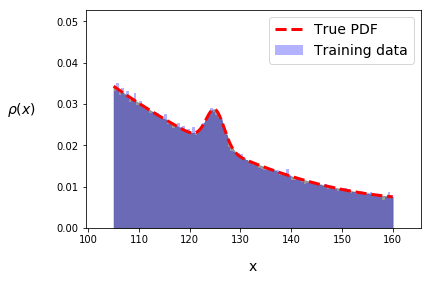

In [6]:
train_DS = generate_data(num_train)
plot_points(train_DS, "Training data")

In [11]:
from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU
from keras.models     import Model, Sequential
from keras.optimizers import Adam

import keras.backend as K

safety_buffer = 10

def cost (y_true, y_pred) :
    print(y_true)
    print(y_pred)
    print("test 1")
    print(y_true.get_shape())
    print(y_pred.get_shape())
    datapoints = y_pred[:,0]
    print(datapoints.get_shape())
    below_range  = K.cast(K.less(datapoints, range_min - safety_buffer), "float32")
    within_range = K.cast(K.less(datapoints, range_max), "float32") * K.cast(K.greater(datapoints, range_min), "float32")
    above_range  = K.cast(K.greater(datapoints, range_max + safety_buffer), "float32")
    mask = below_range + within_range + above_range
    print(below_range.get_shape())
    print(within_range.get_shape())
    print(above_range.get_shape())
    print(mask.get_shape())
    print(K.categorical_crossentropy(y_true, y_pred).get_shape())
    return K.dot(mask, K.categorical_crossentropy(y_true, y_pred))


d_in = Input((1,))
d_1  = Dense(128)(d_in)
d_2  = LeakyReLU(0.2)(d_1)
d_3  = Dropout(0.3)(d_2)
d_4  = Dense(128)(d_3)
d_5  = LeakyReLU(0.2)(d_4)
d_6  = Dropout(0.3)(d_5)
d_7  = Dense(80)(d_6)
d_8  = LeakyReLU(0.2)(d_7)
d_9  = Dropout(0.3)(d_8)
d_10 = Dense(64)(d_9)
d_11 = LeakyReLU(0.2)(d_10)
d_12 = Dropout(0.3)(d_11)
d_13 = Dense(2, activation="softmax")(d_12)
#d    = Model(inputs=d_in, outputs=d_13, name="Discriminator")


d = Sequential(name="Discriminator")
d.add(Dense(256, input_shape=(1,)))
d.add(Dropout(0.2))
d.add(Dense(256))
d.add(Dropout(0.2))
d.add(Dense(256))
d.add(Dropout(0.2))
d.add(Dense(2, activation="softmax"))
d.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
d.summary()

g_in = Input((noise_size,))
g_1  = Dense(50)(g_in)
g_2  = LeakyReLU(0.2)(g_1)
g_3  = BatchNormalization()(g_2)
g_4  = Dense(80)(g_3)
g_5  = LeakyReLU(0.2)(g_4)
g_6  = BatchNormalization()(g_5)
g_7  = Dense(128)(g_6)
g_8  = LeakyReLU(0.2)(g_7)
g_9  = BatchNormalization()(g_8)
g_10 = Dense(128)(g_9)
g_11 = LeakyReLU(0.2)(g_10)
g_12 = BatchNormalization()(g_11)
g_13 = Dense(1, activation="linear")(g_12)
#g    = Model(inputs=[g_in], outputs=[g_13], name="Generator")

g = Sequential(name="Generator")
g.add(Dense(128, input_shape=(noise_size,)))
g.add(BatchNormalization())
g.add(LeakyReLU(0.2))
g.add(Dense(128))
g.add(BatchNormalization())
g.add(LeakyReLU(0.2))
g.add(Dense(256))
g.add(BatchNormalization())
g.add(LeakyReLU(0.2))
g.add(Dense(1, activation="linear"))
g.summary()

gan_in  = Input((noise_size,))
gan_out = d(g(gan_in))
gan = Model(gan_in, gan_out, name="GAN")
d.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
gan.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               512       
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)               

In [12]:
def plot_points_GAN (data, label, epoch, batch_size, d_acc, gan_acc) :
    x = np.linspace(range_min, range_max, 200)
    y = true_pdf(x)
    plt.plot(x, y, "--", linewidth=3, c="r", label="True PDF")
    plt.fill_between(x, np.zeros(shape=x.shape), y, color="gray", alpha=0.8)
    h = plt.hist(data, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue", density=True, alpha=0.3, label=label)
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("x", size=14, labelpad=10)
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    y_max = 1.5*max([max(y),max(h[0])])
    plt.gca().set_ylim([0, y_max])
    plt.text(range_min+0.*1.1*range_width   , 0.84*y_max, "GAN test", size=18, style="italic", weight="bold")
    plt.text(range_min+0.750*1.1*range_width, 0.68*y_max, f"Epoch: {epoch}")
    plt.text(range_min+0.683*1.1*range_width, 0.61*y_max, f"Batch size: {batch_size}")
    plt.text(range_min+0.780*1.1*range_width, 0.54*y_max, r"$\epsilon_{\rm disc}$: "+f"{int(100.*d_acc)}%")
    #plt.text(range_min+0.780*(range_max-range_min), 0.47*y_max, r"$\epsilon_{\rm GAN}$: "+f"{int(100.*gan_acc)}%")
    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    plt.savefig(f"out/1D_GAN_test/Train_epoch{epoch}.png", dpi=96)
    plt.show()

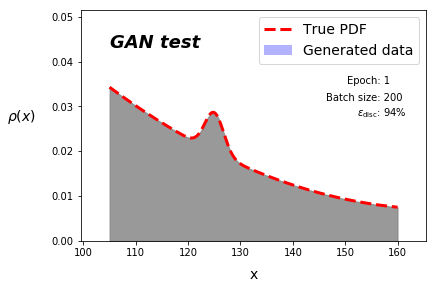

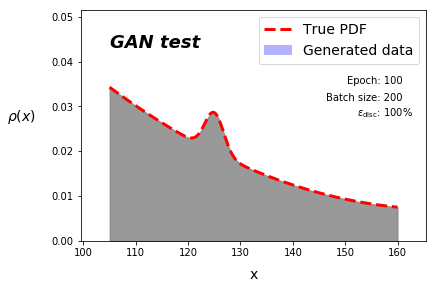

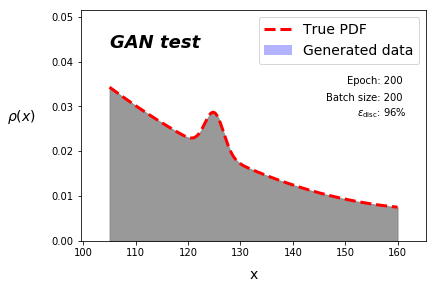

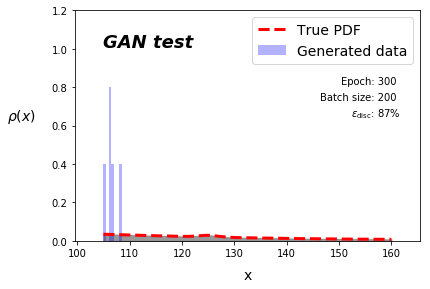

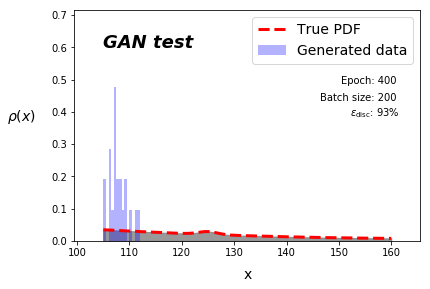

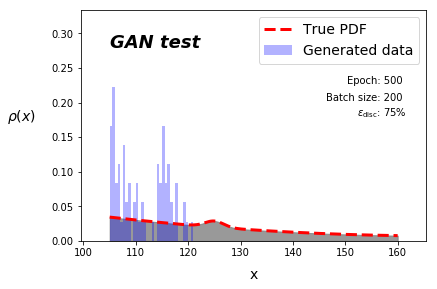

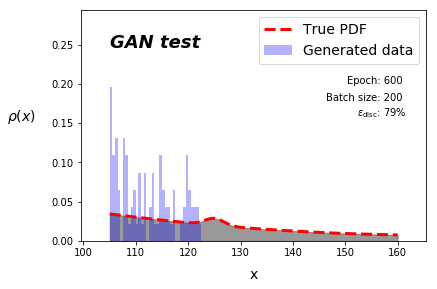

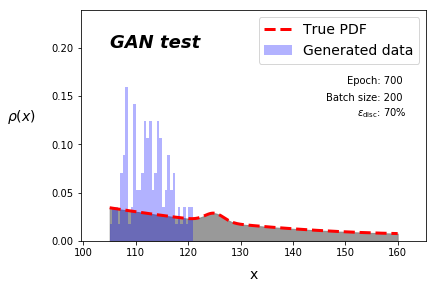

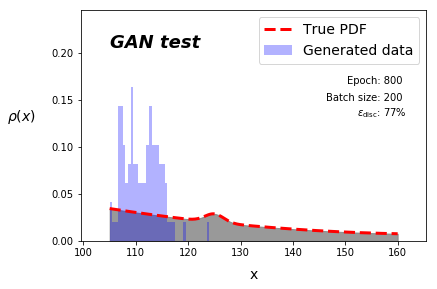

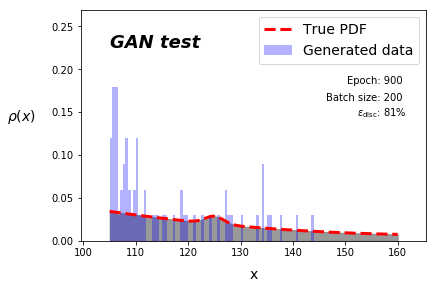

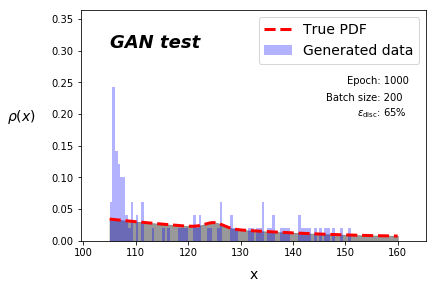

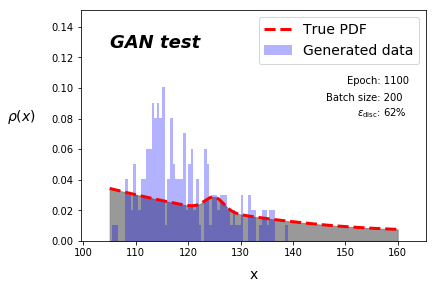

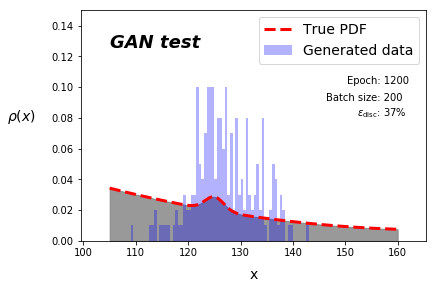

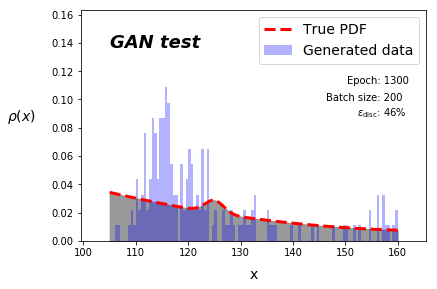

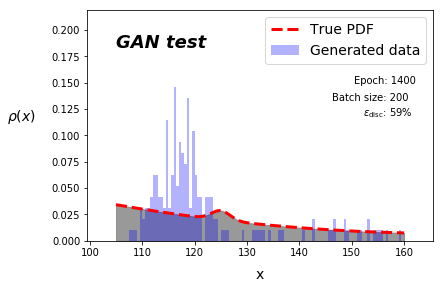

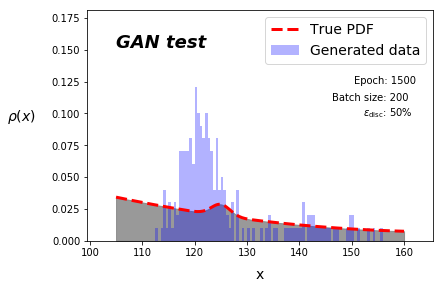

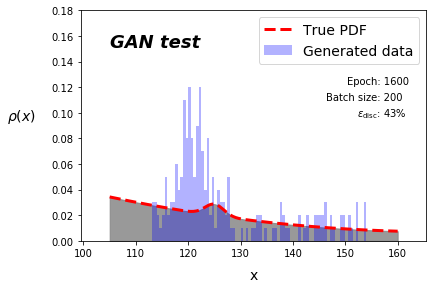

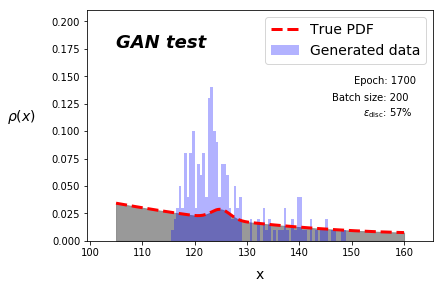

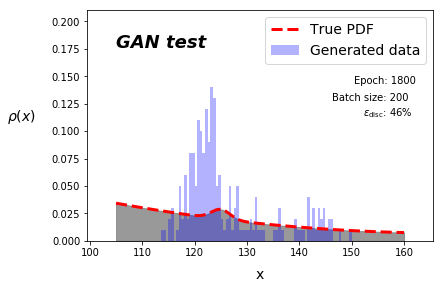

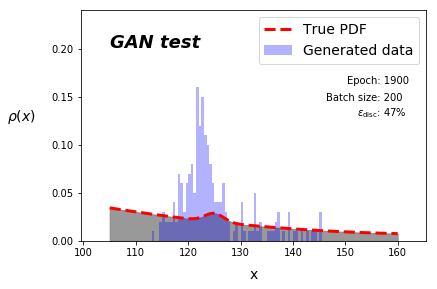

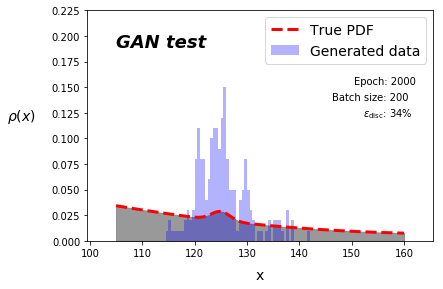

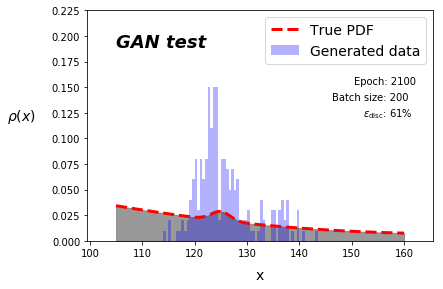

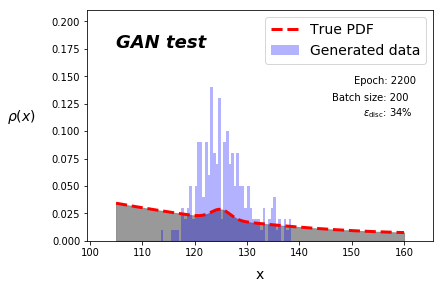

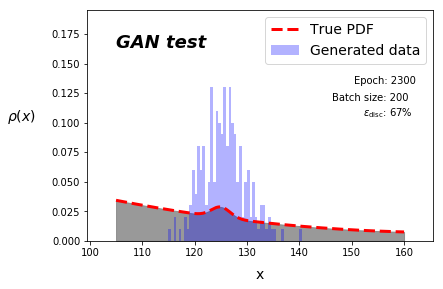

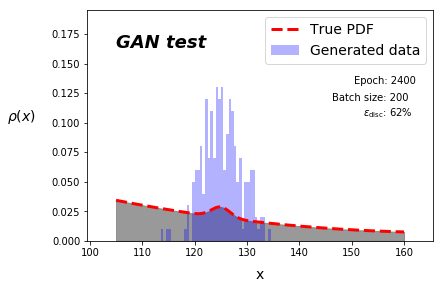

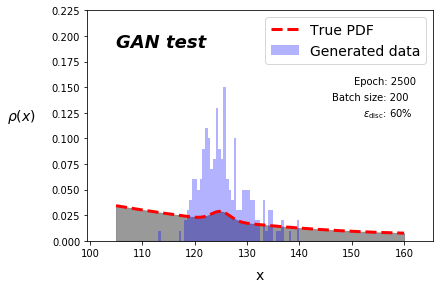

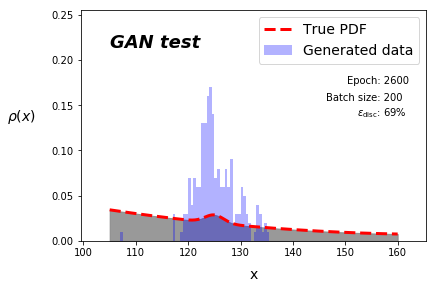

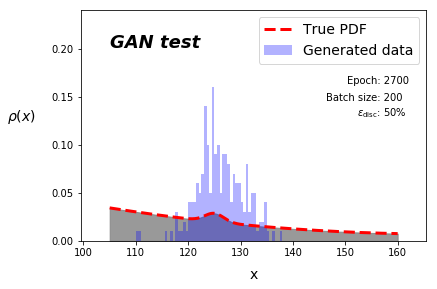

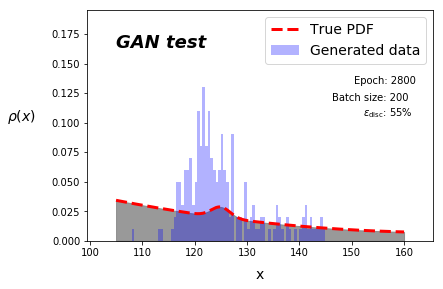

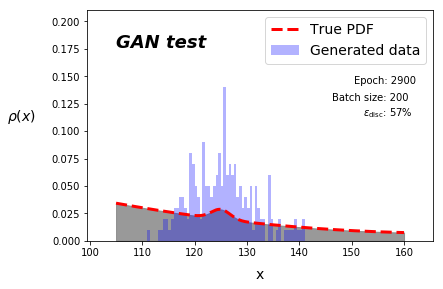

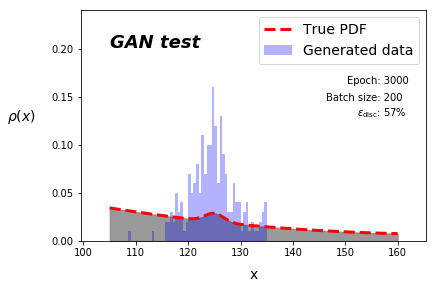

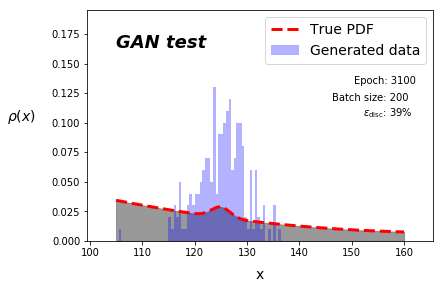

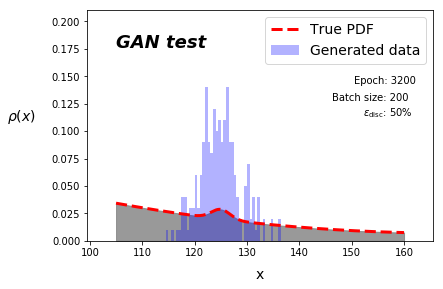

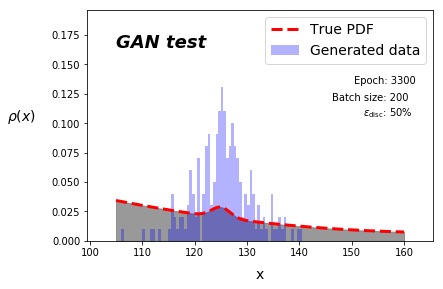

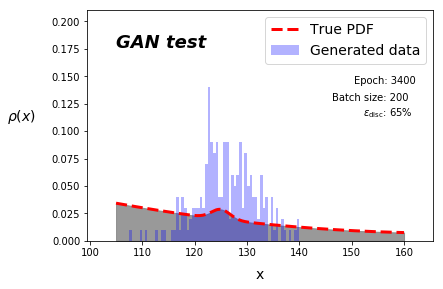

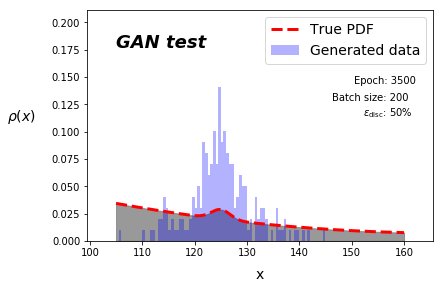

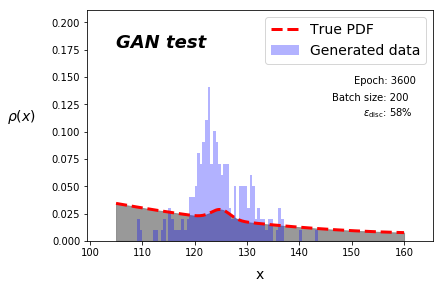

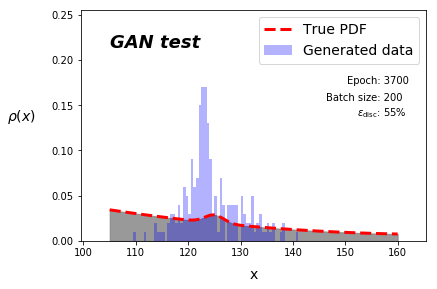

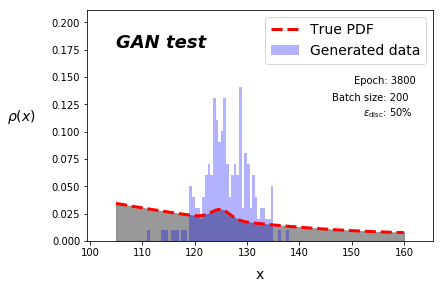

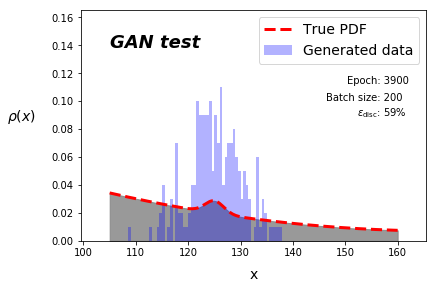

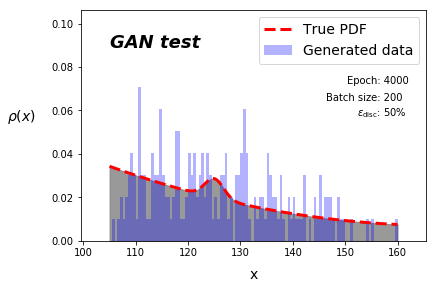

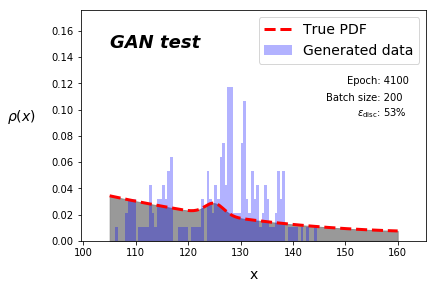

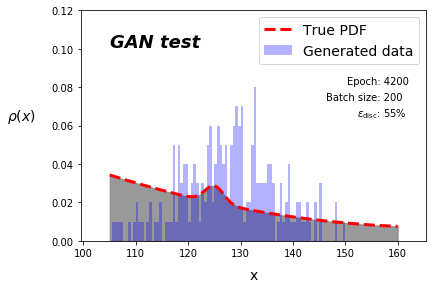

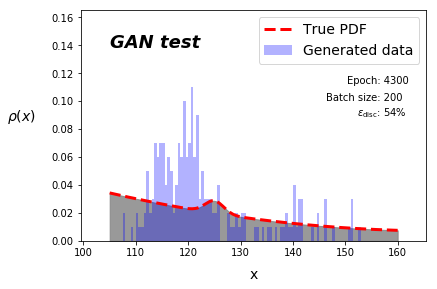

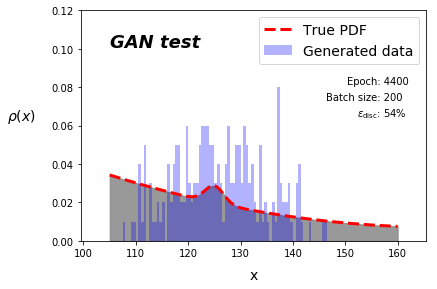

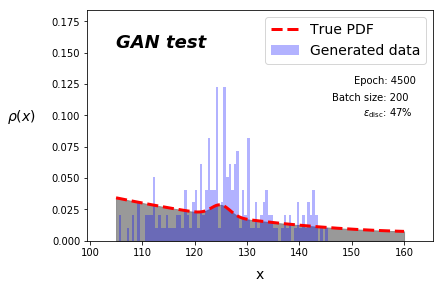

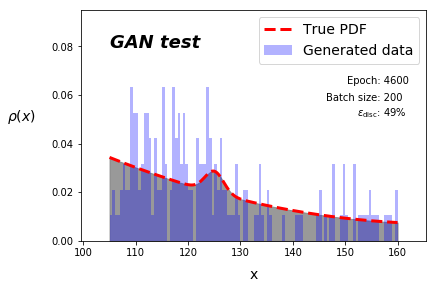

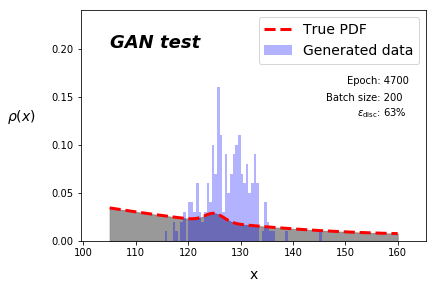

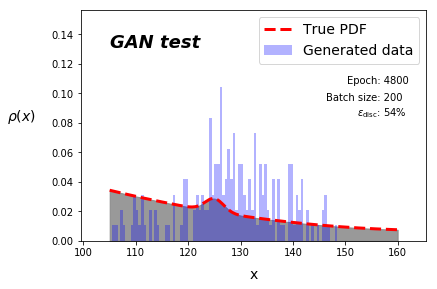

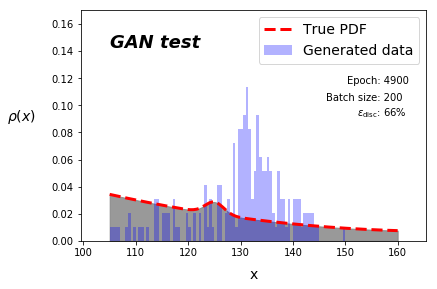

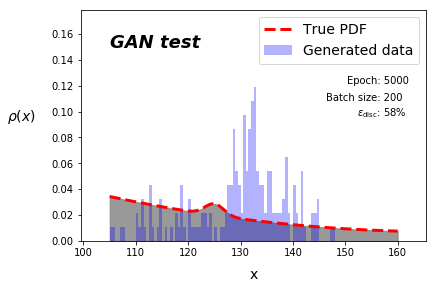

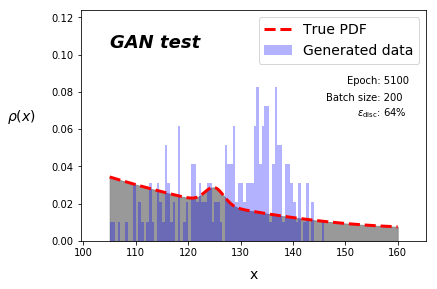

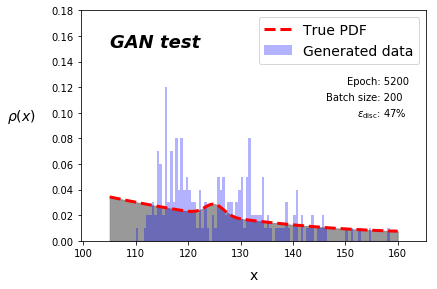

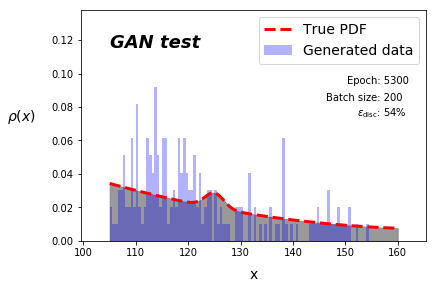

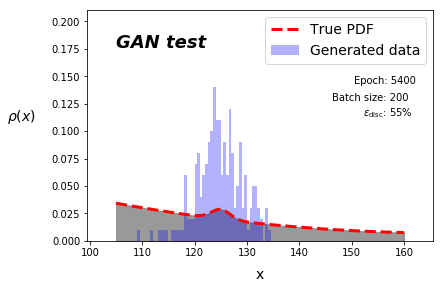

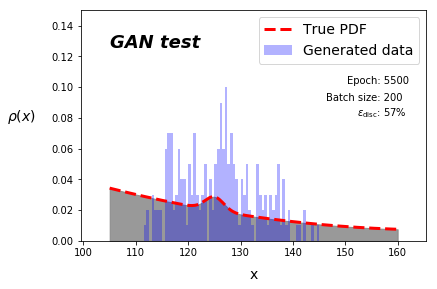

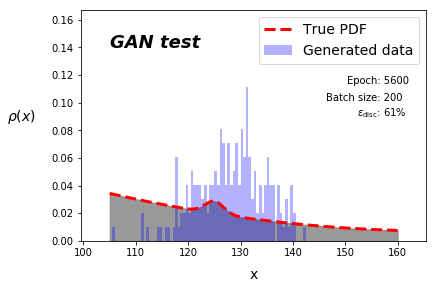

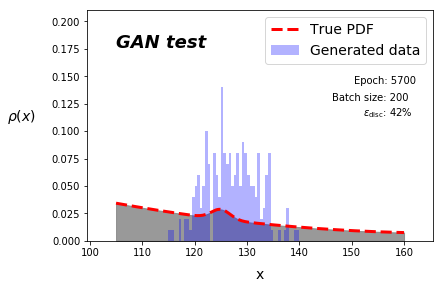

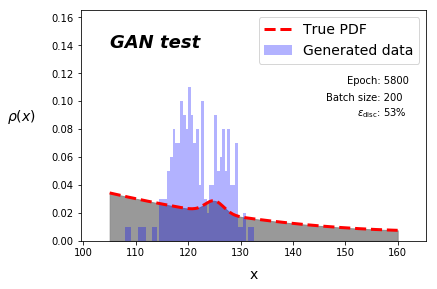

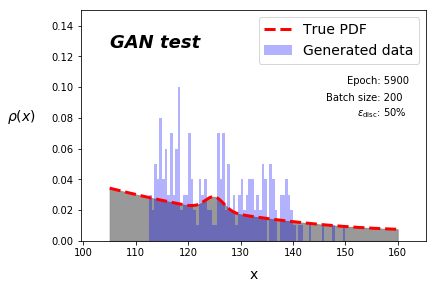

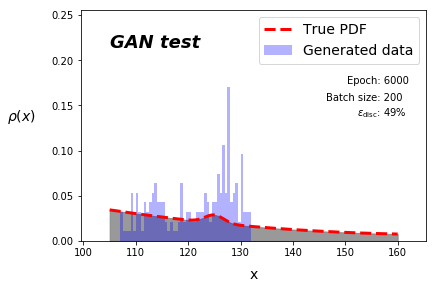

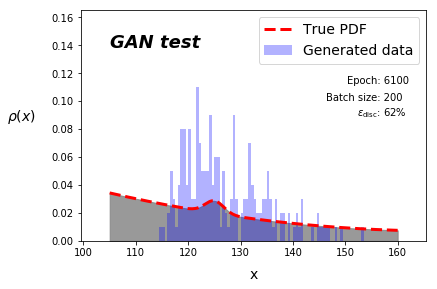

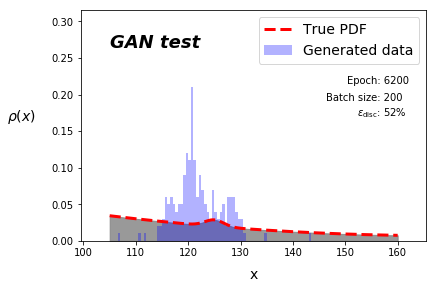

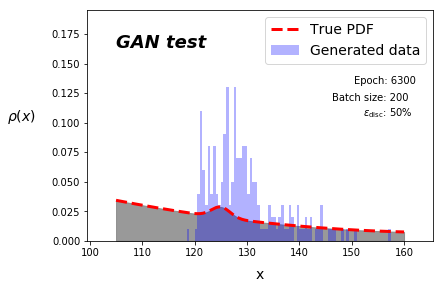

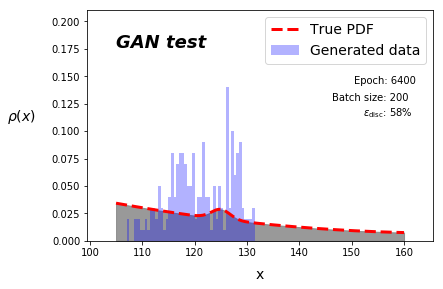

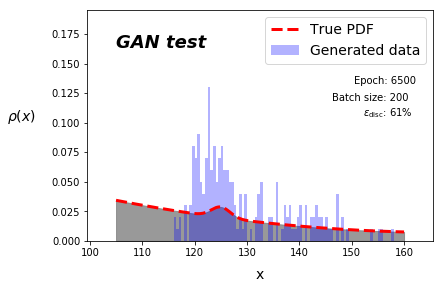

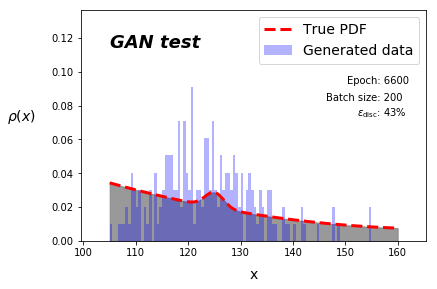

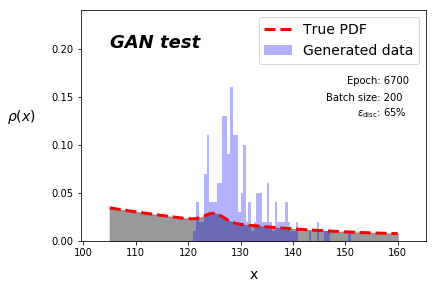

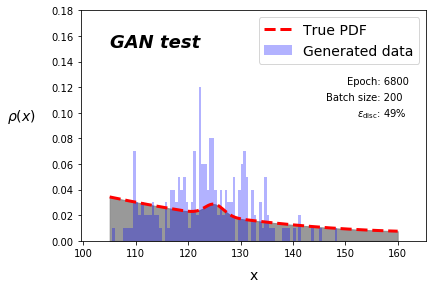

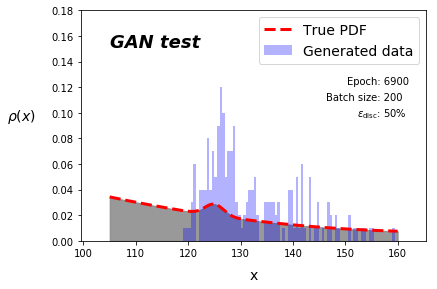

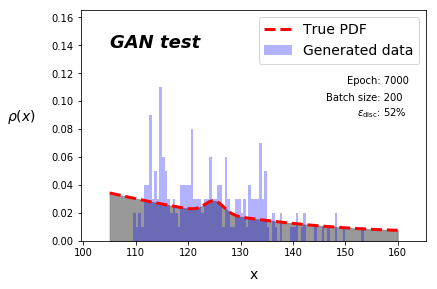

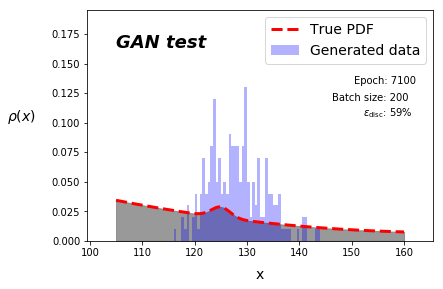

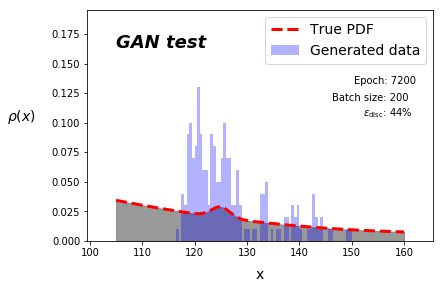

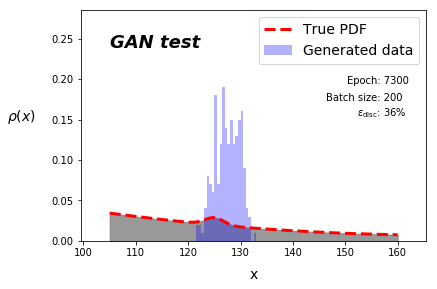

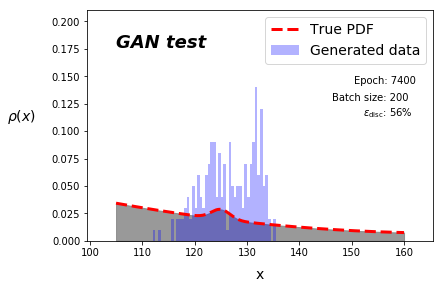

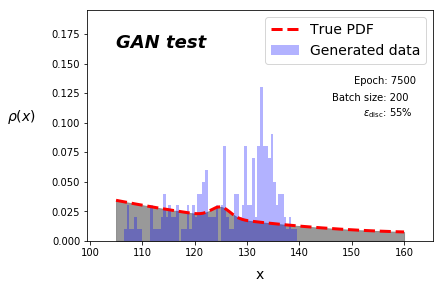

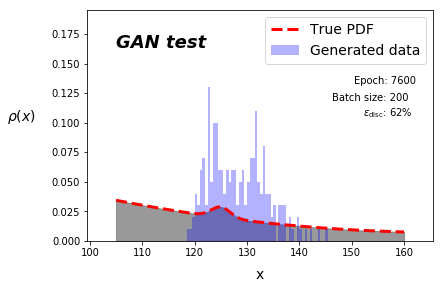

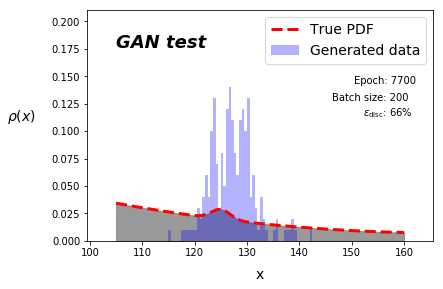

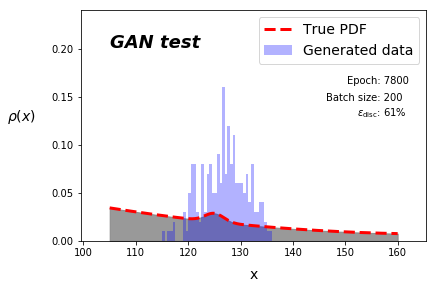

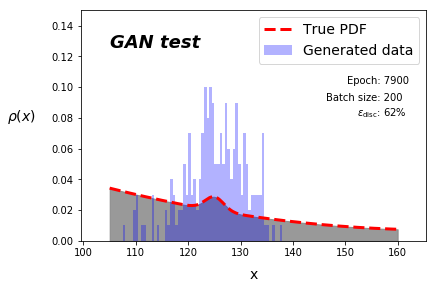

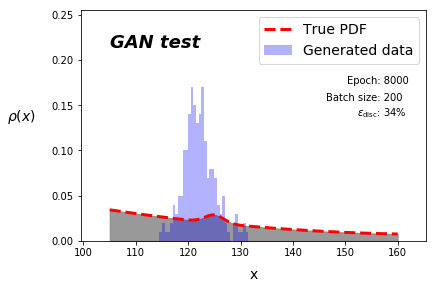

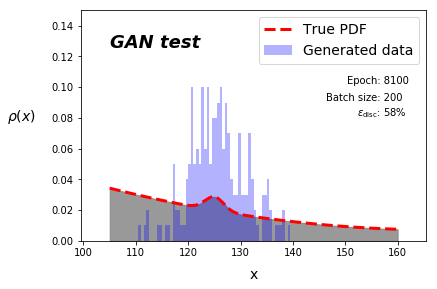

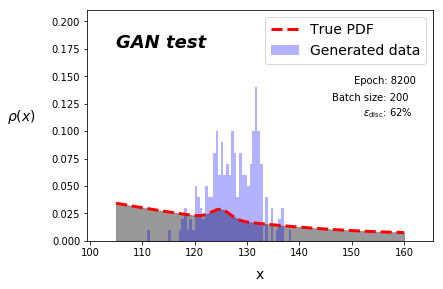

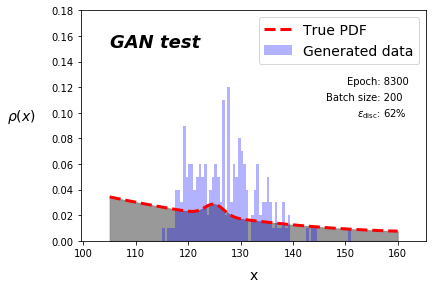

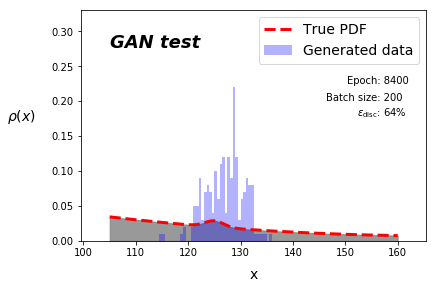

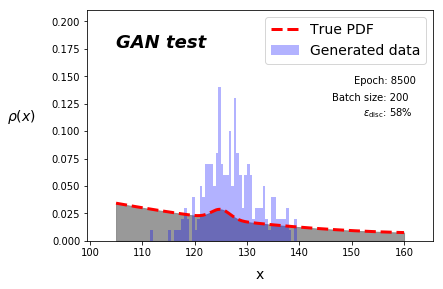

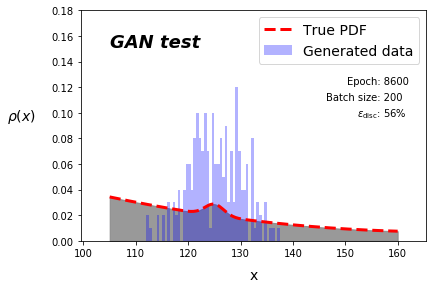

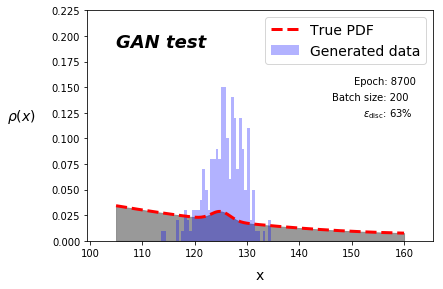

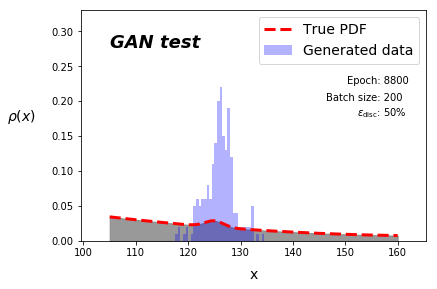

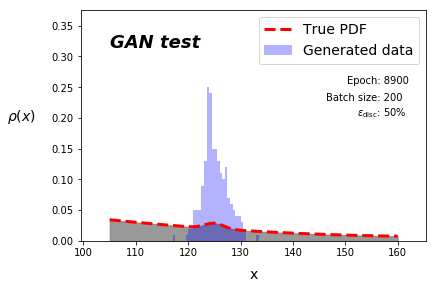

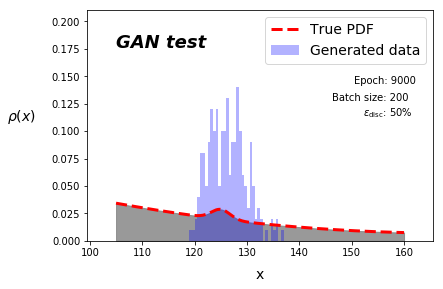

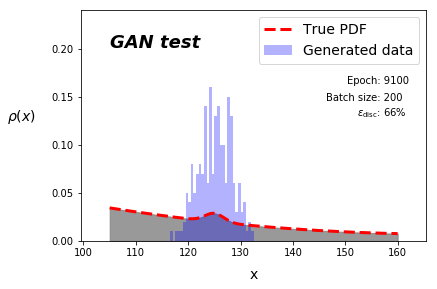

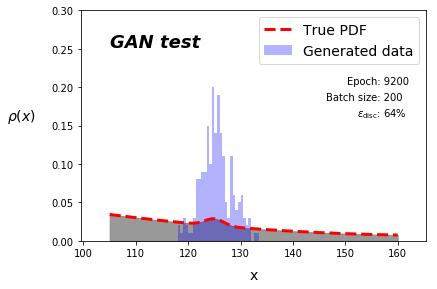

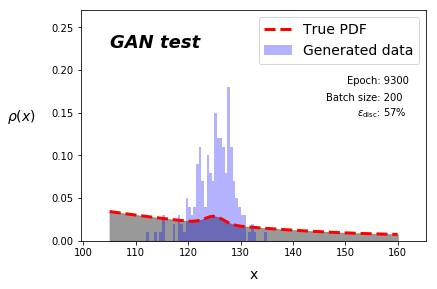

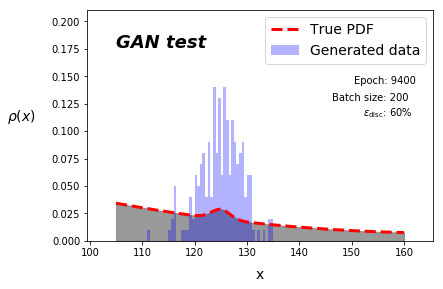

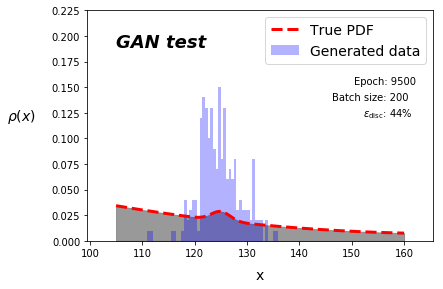

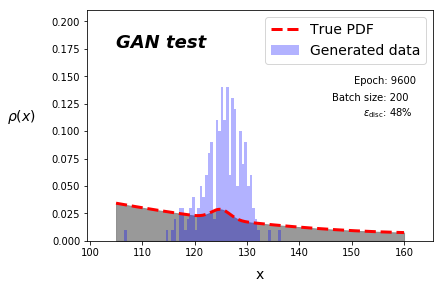

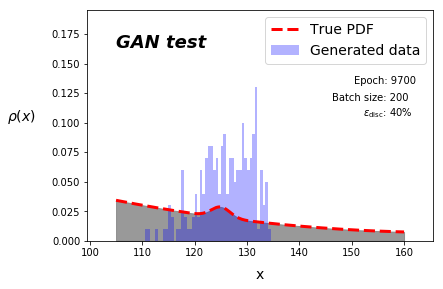

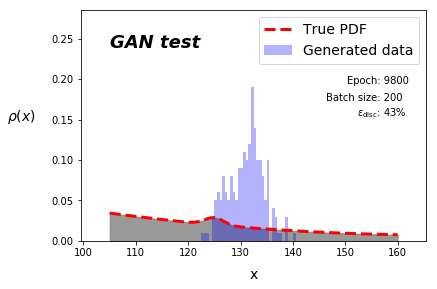

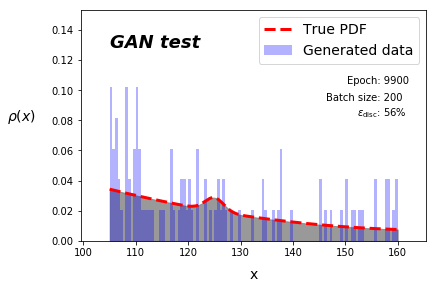

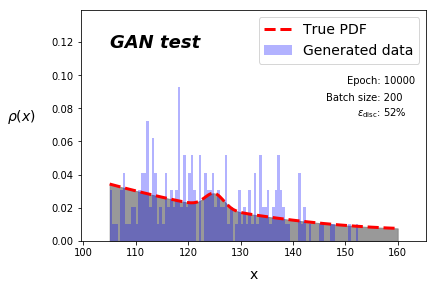

In [13]:
#  Train GAN

epochs     = 10000
batch_size = 200
max_D_itrs_per_G_itr_e70 = 4
max_D_itrs_per_G_itr_e52 = 3

train_median, train_std = np.median(train_DS), np.std(train_DS)

def update_batch_size (gen_DS) :
    global batch_size
    gen_median, gen_std = np.median(gen_DS.flatten()), np.std(gen_DS.flatten())
    if np.fabs((gen_median-train_median)/train_std) > 1./np.sqrt(batch_size) : return
    if np.fabs((gen_std/train_std)-1) > 1./np.sqrt(batch_size) : return
    batch_size = min(100+batch_size, num_train)
    
epochs_saved = []
for e in range(epochs) :
    noise  = np.random.normal(size=(batch_size, noise_size))
    batch_DS = train_DS[np.random.randint(0, len(train_DS), batch_size)].reshape(batch_size, 1)
    gen_DS   = g.predict(noise)
    real_label = np.array([[1., 0.] for i in range(batch_size)])
    fake_label = np.array([[0., 1.] for i in range(batch_size)])
    X = np.concatenate([batch_DS  , gen_DS    ])
    Y = np.concatenate([real_label, fake_label])
    
    d.trainable = True
    d_loss, d_acc = d.train_on_batch(X, Y)
    num_itr = 0
    while num_itr < max_D_itrs_per_G_itr_e70 and d_acc < 0.7 :
        d_loss, d_acc = d.train_on_batch(X, Y)
        num_itr = num_itr + 1
    while num_itr < max_D_itrs_per_G_itr_e52 and d_acc < 0.52 :
        d_loss, d_acc = d.train_on_batch(X, Y)
        num_itr = num_itr + 1
        
    noise  = np.random.normal(size=(batch_size, noise_size))
    d.trainable = False
    gan.train_on_batch(noise, real_label)
    
    if e == 0 or (e+1) % 100 == 0 :
        noise  = np.random.normal(size=(batch_size, noise_size))
        gen_DS = g.predict(noise)
        plot_points_GAN(gen_DS, f"Generated data", 
                    epoch=e+1, 
                    batch_size=batch_size, 
                    d_acc=d.evaluate(X, Y, verbose=0)[1], 
                    gan_acc=gan.evaluate(noise, real_label, verbose=0)[1])
        update_batch_size(gen_DS)
        epochs_saved.append(e+1)



In [10]:

#noise  = np.random.normal(size=(num_test, noise_size))
#gen_DS = g.predict(noise)
#plot_points(gen_DS, "Generated data")